## Import Modules

We are going to import some necessary modules.

In [11]:
# link to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,Dropout,Input, AveragePooling2D, Activation,Conv2D, MaxPooling2D,BatchNormalization,Concatenate,ZeroPadding2D
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.models 
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import copy

## Import Data and visualize the data

Import the data from keras datasets, split the dataset into train and test data and visualize the data before set up a model


In [14]:
#import the cifar10 data
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 6s 0us/step


In [15]:
#print the size of the cifar10 dataset
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


In [16]:
#The classes of the data
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [17]:
#data visualization
def display_overall_images(x, y_prediction, y, title):
  n = 10
  indexes = np.random.choice(len(y_prediction), size=n) #choose ten images
  x_n = x[indexes] #images
  y_prediction_n = y_prediction[indexes]
  y_prediction_n = y_prediction_n.reshape((n,)) #images' prediction data
  labels_n = y[indexes] #images' label
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([]) 
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = y_prediction_n[i] 
    plt.title('{}'.format(classes[labels_n[i][0]])) #title of each sub-image:label
    plt.xlabel(classes[class_index]) #x label:prediction label
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_n[i])
  print('The title of each image is its True label')
  print('The x-label of each image is its Prediction label')

def display_one_image(x,y_predict,y,index):
  fig=plt.figure(figsize=(4,4))
  plt.title('Image and its label')
  class_index=y_predict[index]
  plt.xlabel(classes[int(y[index])]) #it's label
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x[index])
  print('The prediction of this image is {}'.format(classes[int(y_predict[index])])) #prediction label

The title of each image is its True label
The x-label of each image is its Prediction label


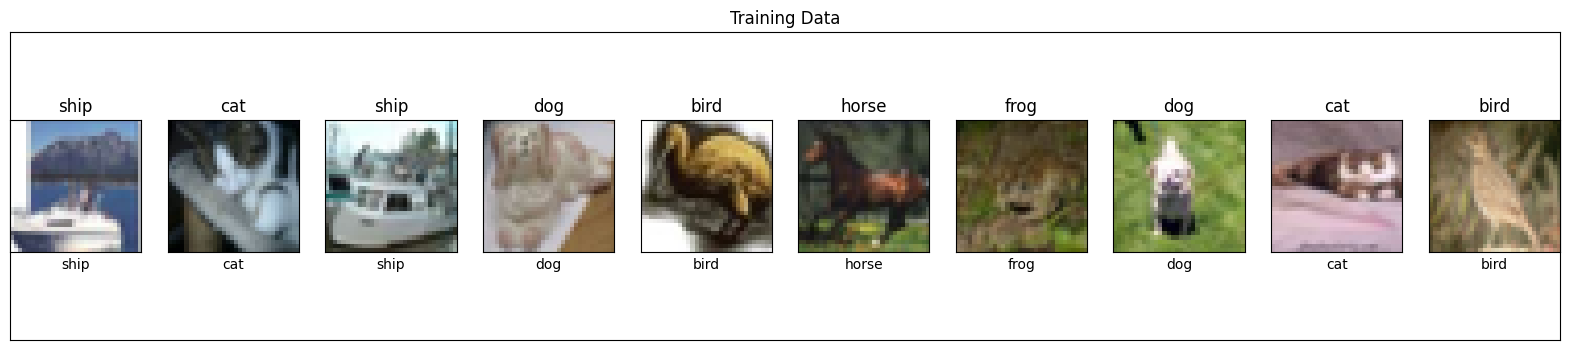

In [18]:
display_overall_images(x_train, y_train, y_train, "Training Data" )
#get ten images to visualize

The prediction of this image is automobile


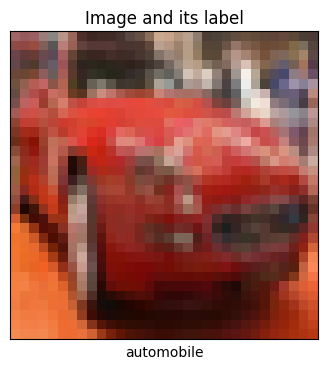

In [19]:
display_one_image(x_train,y_train,y_train,5)
#choose one image to visualize

In [20]:
# Normalizing
x_train=x_train/255
x_test=x_test/255

In [21]:
#One hot encoding
# y_val_cat=to_categorical(y_val,10)
y_train_cat=to_categorical(y_train,10)
y_test_cat=to_categorical(y_test,10)

In [22]:
def random_crop(image):
    # Define the crop parameters (replace these with your desired crop size)
    crop_height = 24
    crop_width = 24

    height, width, _ = image.shape
    offset_height = np.random.randint(0, height - crop_height + 1)
    offset_width = np.random.randint(0, width - crop_width + 1)

    cropped_image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, crop_height, crop_width)
    return cropped_image.numpy()

In [23]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    preprocessing_function=random_crop,
    fill_mode='reflect'
)
datagen.fit(x_train)
print(x_train.shape)

(50000, 32, 32, 3)


# Resnet 18 Model fix


In [50]:
conv = Conv2D
bn = BatchNormalization
concat = Concatenate
pool = AveragePooling2D
pad = ZeroPadding2D

def conv_block(input, filters):
    conv1 = Conv2D(filters=filters,kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding="same")(input)
    bn1 = bn()(conv1)
    conv2 = Conv2D(filters=filters,kernel_size=(3,3), activation='relu', kernel_initializer='he_normal', padding="same")(bn1)
    bn2 = bn()(conv2)
    shortcut = concat()([input,bn2])
    return shortcut

def make_blocks(x, filters, layers):
    for i in range(layers):
        x = conv_block(x,filters)
    return x


input = Input((32,32,3))
conv1 = conv(filters=16, kernel_size=(3,3), strides=1, activation='relu', kernel_initializer='he_normal', padding="same")(input)
bn1 = bn()(conv1)
res1 = make_blocks(bn1,16,9)
avg1 = pool(pool_size=(3,3))(res1)
res2 = make_blocks(avg1,32,9)
avg2 = pool(pool_size=(3,3))(res2)
res3 = make_blocks(avg2,64,9)
avg3 = pool(pool_size=(3,3))(res3)
flat = Flatten()(avg3)
dense = Dense(10,activation='softmax')(flat)

resnet_fix = tensorflow.keras.models.Model(inputs=input,outputs=dense)#flat
resnet_fix.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_110 (Conv2D)            (None, 32, 32, 16)   448         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_110 (Batch  (None, 32, 32, 16)  64          ['conv2d_110[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_111 (Conv2D)            (None, 32, 32, 16)   2320        ['batch_normalization_110[0

In [51]:
resnet_fix.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
#train and save the best model
saved_model_accuracy=0
index=0
epoch=50
loss_train_val=[]
loss_test_val=[]
sparse_categorical_accuracy=[]
val_sparse_categorical_accuracy=[]


for i in range(epoch):
  print('Epoch {}/{}'.format(i+1,epoch))
  history2=resnet_fix.fit(x_train,y_train_cat,epochs=1,validation_data=(x_test,y_test_cat))
  evaluation = resnet_fix.evaluate(x_test, y_test_cat)
  loss_train_val.append(history2.history['loss'][0])
  loss_test_val.append(history2.history['val_loss'][0])
  sparse_categorical_accuracy.append(history2.history['accuracy'][0])
  val_sparse_categorical_accuracy.append(history2.history['val_accuracy'][0])
  if evaluation[1]>saved_model_accuracy:
    saved_evaluation=copy.deepcopy(evaluation)
    saved_model_accuracy=copy.copy(evaluation[1])
    resnet_fix.save(' Best_model.h5')
    index=i

print('the best accuracy is {}%'.format(saved_evaluation[1]*100))
print('the best loss is {}'.format(saved_evaluation[0]))
print('the best model is {}-th epoch'.format(index+1))

Epoch 1/50
313/313 [==============================] - 2s 8ms/step - loss: 0.8001 - accuracy: 0.7305
Epoch 2/50
313/313 [==============================] - 2s 8ms/step - loss: 0.6020 - accuracy: 0.7938
Epoch 3/50
313/313 [==============================] - 3s 8ms/step - loss: 0.5770 - accuracy: 0.8049
Epoch 4/50
313/313 [==============================] - 3s 8ms/step - loss: 0.5263 - accuracy: 0.8277
Epoch 5/50
313/313 [==============================] - 3s 9ms/step - loss: 0.4857 - accuracy: 0.8488
Epoch 6/50
313/313 [==============================] - 3s 8ms/step - loss: 0.5187 - accuracy: 0.8457
Epoch 7/50
313/313 [==============================] - 2s 8ms/step - loss: 0.6336 - accuracy: 0.8224
Epoch 8/50
313/313 [==============================] - 2s 8ms/step - loss: 0.5807 - accuracy: 0.8445
Epoch 9/50
313/313 [==============================] - 2s 8ms/step - loss: 0.5610 - accuracy: 0.8533
Epoch 10/50
313/313 [==============================] - 2s 8ms/step - loss: 0.5980 - accuracy: 0.8550

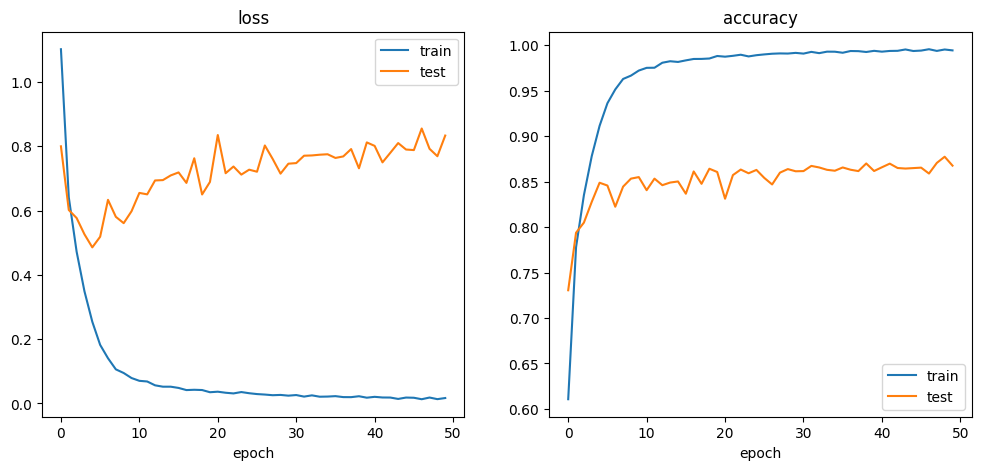

In [53]:
## visualize the process of our training

 
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(loss_train_val,label='train')
plt.plot(loss_test_val,label='test')
plt.title("loss")
plt.xlabel("epoch")
plt.legend()
plt.subplot(122)
plt.plot(sparse_categorical_accuracy,label='train')
plt.plot(val_sparse_categorical_accuracy,label='test')
plt.title("accuracy")
plt.xlabel("epoch")
plt.legend()
 
plt.show()



In [54]:
new_model = tensorflow.keras.models.load_model(' Best_model.h5')

In [55]:
evaluation = new_model.evaluate(x_test, y_test_cat)
print('the best accuracy is {}%'.format(saved_evaluation[1]*100))
print('the best loss is {}'.format(saved_evaluation[0]))

313/313 [==============================] - 4s 9ms/step - loss: 0.7693 - accuracy: 0.8774
the best accuracy is 87.73999810218811%
the best loss is 0.7693378925323486


In [56]:
#predict the test data and get it's label
y_prediction=new_model.predict(x_test)
y_prediction=np.argmax(y_prediction, axis=1)
y_prediction


313/313 [==============================] - 3s 6ms/step


array([3, 8, 1, ..., 5, 1, 7])

The title of each image is its True label
The x-label of each image is its Prediction label


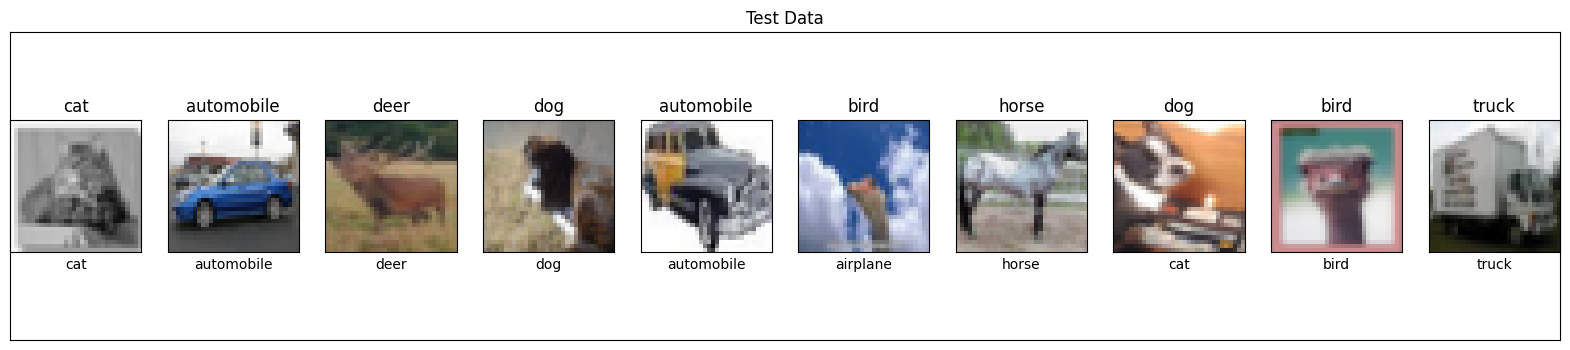

In [57]:
display_overall_images(x_test, y_prediction, y_test, "Test Data" )
#visualize the result of test data

313/313 [==============================] - 4s 8ms/step


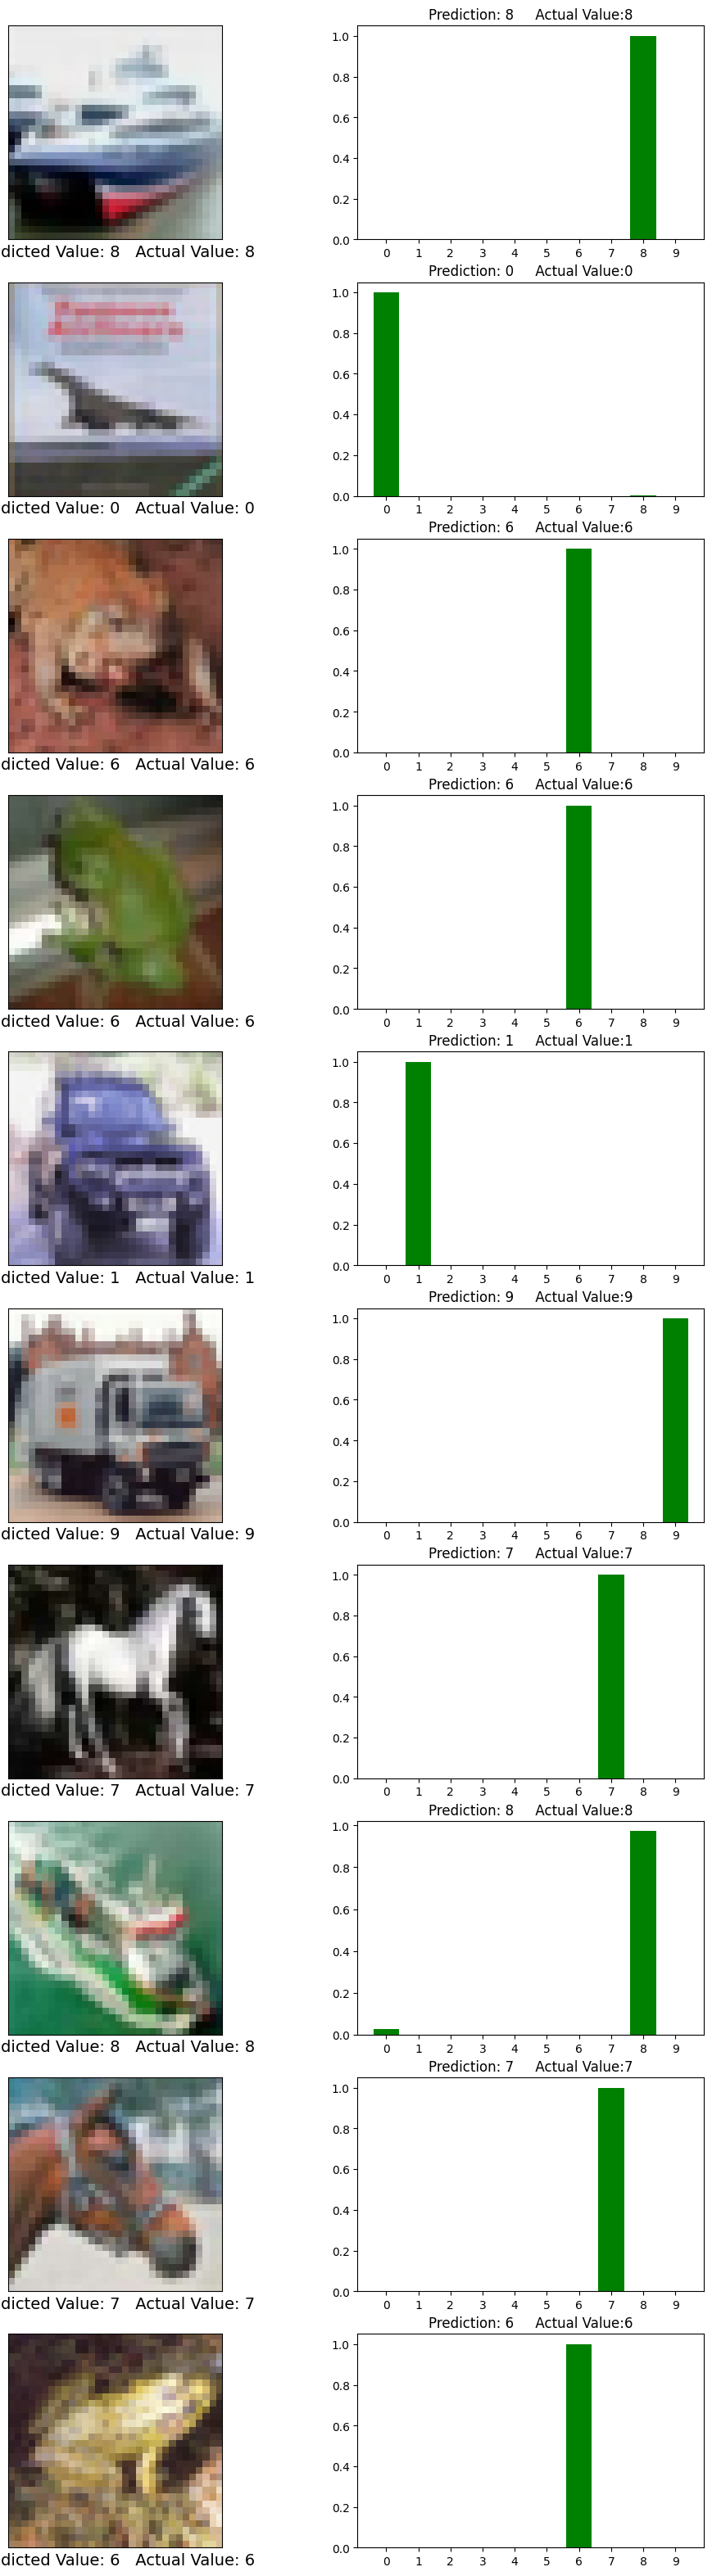

In [58]:
#the result of each category
prediction=resnet_fix.predict(x_test)
pre = prediction[:20]
tik = [i for i in range(0,10)]
plt.figure(figsize=(12,40))
for i in range(1,20,2):
    
    
    rel_lable = int(y_test[i])
    pre_lable = np.argmax(pre[i])
    
    if rel_lable==pre_lable:
        color_s = 'g'
    else:
        color_s = 'r'
    
    
    
    plt.subplot(10,2,i)
    plt.imshow(x_test[i])
    plt.xticks([])
    plt.yticks([])
    
    plt.xlabel(f'Predicted Value: {pre_lable}   Actual Value: {rel_lable}',size=14)
 
    
    
    plt.subplot(10,2,i+1) 
    
    
    plt.bar(tik,pre[i],color=color_s)
    plt.xticks(tik)
    plt.title(f"Prediction: {np.argmax(pre[i])}     Actual Value:{rel_lable}"%(np.max(pre[i])))
 
plt.show()

